# Time Series Clustering using DTW KMeans

In this notebook, we will train a KMeans Clustering algorithm based on DTW distances between Time Series data. 

We leverage the [tslearn library](https://tslearn.readthedocs.io/en/stable/index.html) for clustering. The data used in this analysis is publicly available via UCI Archive under [Online Retail II Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II).

We have cleaned and preprocessed this dataset in the optional notebook: 01. Optional - Data Cleaning and Preparation. The reader may directly use the preprocessed data included in the repository under: `./data/df_pivoted.zip` for running this notebook.

Tested with Python3, Pandas version 1.0.5.

*References*
 * Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
 * Direct link to UCI dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
 * tslearn github repo: https://github.com/tslearn-team/tslearn

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# optional - suppress warnings

import warnings
warnings.filterwarnings("ignore")

### Load data

In [3]:
df_pivoted = pd.read_csv('./data/df_pivoted.zip', low_memory=False)

In [4]:
# prepare data to laod to tslearn time_series_dataset object
df_pivoted.set_index('StockCode', inplace=True)

print(df_pivoted.shape, df_pivoted.columns)

df_pivoted.head()

(4605, 374) Index(['2009-12-01 00:00:00', '2009-12-02 00:00:00', '2009-12-03 00:00:00',
       '2009-12-04 00:00:00', '2009-12-05 00:00:00', '2009-12-06 00:00:00',
       '2009-12-07 00:00:00', '2009-12-08 00:00:00', '2009-12-09 00:00:00',
       '2009-12-10 00:00:00',
       ...
       '2010-11-30 00:00:00', '2010-12-01 00:00:00', '2010-12-02 00:00:00',
       '2010-12-03 00:00:00', '2010-12-04 00:00:00', '2010-12-05 00:00:00',
       '2010-12-06 00:00:00', '2010-12-07 00:00:00', '2010-12-08 00:00:00',
       '2010-12-09 00:00:00'],
      dtype='object', length=374)


,2009-12-01 00:00:00,2009-12-02 00:00:00,2009-12-03 00:00:00,2009-12-04 00:00:00,2009-12-05 00:00:00,2009-12-06 00:00:00,2009-12-07 00:00:00,2009-12-08 00:00:00,2009-12-09 00:00:00,2009-12-10 00:00:00,...,2010-11-30 00:00:00,2010-12-01 00:00:00,2010-12-02 00:00:00,2010-12-03 00:00:00,2010-12-04 00:00:00,2010-12-05 00:00:00,2010-12-06 00:00:00,2010-12-07 00:00:00,2010-12-08 00:00:00,2010-12-09 00:00:00
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,12.0,0.0,7.0,73.0,0.0,49.0,2.0,12.0,0.0,1.0,...,12.0,60.0,1.0,8.0,0.0,1.0,25.0,8.0,13.0,44.0
10080,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10109,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,60.0,10.0,0.0,30.0,0.0,0.0,0.0,1.0,1.0,6.0,...,10.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,0.0
10125,5.0,0.0,0.0,46.0,0.0,8.0,20.0,1.0,22.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,40.0,0.0


## DTW KMeans Clustering

In [5]:
%pip install tslearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

In [7]:
%%time

# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

(4605, 374, 1) (4605, 374, 1)
CPU times: user 334 ms, sys: 34.4 ms, total: 368 ms
Wall time: 355 ms


In [8]:
# create required directory structure
dir_paths = ['./tsl', './tsl/models', './tsl/plots']

for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

### Perform clustering

With 12 cores, the clustering operation can take roughly half an hour. Your mileage may vary depending on your machine's configuration. `n_jobs = -1` ensures that the training uses all available cores on your machine.

Other alternative to the distance metric is "Soft-DTW" which may produce higher separation at a higher compute cost. Please see the `tslearn` documentation [link](https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py) for more details.

Finding the optimal number of clusters to use - Adding more clusters decreases the inertia value but the information contained in each cluster also decreases. Hence we want to have a small cluster size with a relatively small inertia value. As with finding the optimal number of clusters, the elbow heuristic works well here. Also, clustering techniques are not advised for datasets with fewer than a thousand time series since this could have limiting effect on deep learning models.

The next cell execution could take around 140 minutes with 16 vCPU (ml.c5.4xlarge). If you want you could skip it and move to a next. 

CPU times: user 2h 18min 17s, sys: 41min 20s, total: 2h 59min 37s
Wall time: 1h 24min 44s


Text(0, 0.5, 'WCSSS')

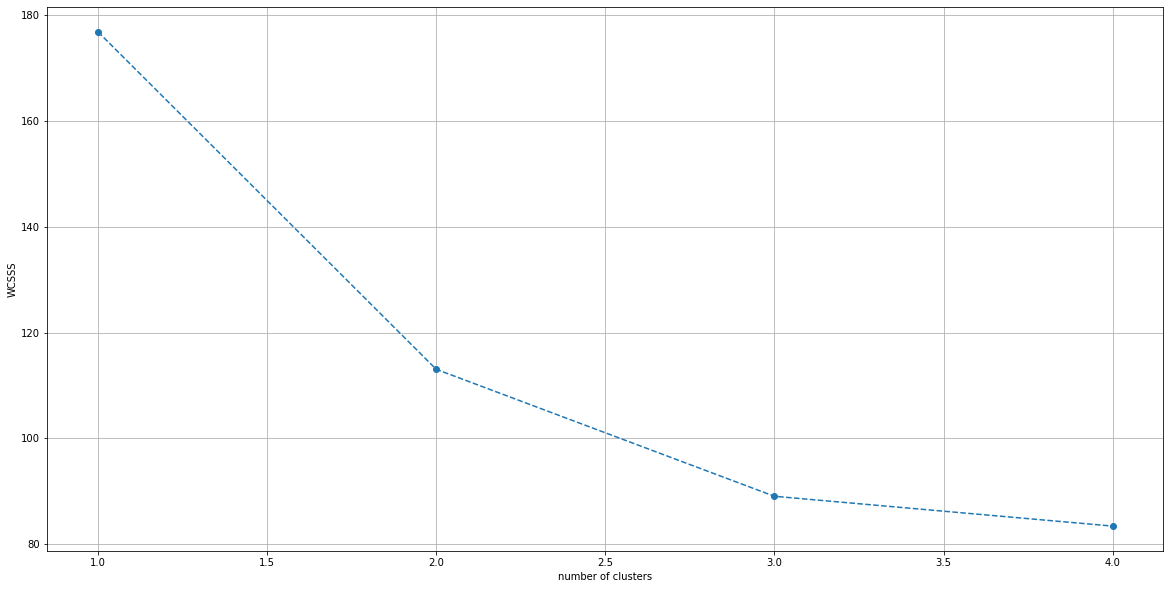

In [ ]:
%%time

# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"

wcss = []

for i in range(1,5):
    model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
    model.fit_predict(X_train)
    wcss.append(model.inertia_)

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1,5),wcss,marker='o',linestyle='--')
plt.xlabel('number of clusters')
plt.ylabel('WCSSS');

In [10]:
%%time

# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"

# cluster configuration
N_CLUSTERS = 2

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)

y_pred = model.fit_predict(X_train)

model.to_pickle(f"./tsl/models/{algo}.pkl")

CPU times: user 45min 55s, sys: 13min 14s, total: 59min 10s
Wall time: 30min 32s


In [11]:
# backup clustering results
np.save(f"./data/tls_{algo}_cluster_labels", y_pred)

Let us plot the different clusters to visually inspect the homogeneity of the cluster composition.

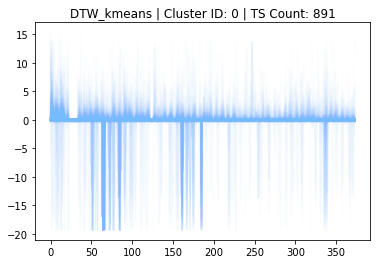

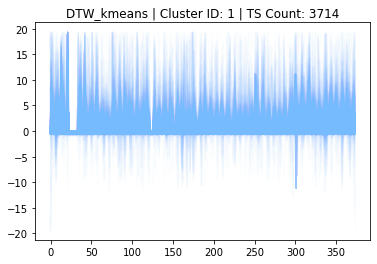

CPU times: user 7.23 s, sys: 364 ms, total: 7.59 s
Wall time: 6.88 s


In [12]:
%%time

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.025)
    fig.savefig(f"./tsl/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

## Generate TTS for different clusters

We can now split the TTS into clusters based on the labels for the different items

In [13]:
# convert data to TTS format expected by Forecast service
df_pivoted.reset_index(inplace=True)

df_tts = pd.melt(df_pivoted, id_vars=['StockCode'])
df_tts.columns = ['item_id', 'timestamp', 'target_value']
df_tts['timestamp'] = df_tts['timestamp'].str[:10]  # keep only the date part

print(df_tts.shape, df_tts.dtypes)

df_tts.head()

(1722270, 3) item_id          object
timestamp        object
target_value    float64
dtype: object


,item_id,timestamp,target_value
0,10002,2009-12-01,12.0
1,10080,2009-12-01,0.0
2,10109,2009-12-01,0.0
3,10120,2009-12-01,60.0
4,10125,2009-12-01,5.0


### Train - Hold-out Split

Hold-out set offers a way for verifying model performance on unseen data. With this dataset, we are looking to forecast a week out (Forecast Horizon = 1 Week) and therefore leave out a week worth of data out from the TTS as holdout set.

In [14]:
min(df_tts['timestamp']), max(df_tts['timestamp'])

('2009-12-01', '2010-12-09')

In [15]:
df_train = df_tts[df_tts['timestamp'] < '2010-12-03']
df_test = df_tts[df_tts['timestamp'] > '2010-12-02']

df_tts.shape, df_train.shape, df_test.shape

((1722270, 3), (1690035, 3), (32235, 3))

In [16]:
# verify that we have adequate coverage across train and test
df_tts.item_id.nunique(), df_train.item_id.nunique(), df_test.item_id.nunique()

(4605, 4605, 4605)

## Split data into clusters

In [17]:
# if restarting, reload the cluster labels
y_pred = np.load(f"./data/tls_{algo}_cluster_labels.npy")

print(y_pred)

[1 1 0 ... 0 0 1]


In [18]:
# lookup dataframe with item_ids and corresponding labels
df_lbl = pd.DataFrame()
df_lbl['item_id'] = df_pivoted['StockCode']
df_lbl['label'] = y_pred

df_lbl.shape, df_lbl.dtypes

((4605, 2),
 item_id    object
 label       int64
 dtype: object)

In [19]:
# merge labels back to the TTS
df_mrg = df_train.merge(df_lbl, how='left')
df_mrg_test = df_test.merge(df_lbl, how='left')

print(df_mrg.shape, df_train.shape)
print(df_mrg_test.shape, df_test.shape)

(1690035, 4) (1690035, 3)
(32235, 4) (32235, 3)


In [20]:
df_mrg.sample(5)

,item_id,timestamp,target_value,label
1191247,35638A,2010-08-16,0.0,0
320695,90188,2010-02-08,0.0,0
1111322,22322,2010-07-30,0.0,1
1531250,72778,2010-10-29,0.0,1
1668645,22450,2010-11-28,0.0,0


In [21]:
# create required directory structure
dir_paths = ['./train']
for i in range(N_CLUSTERS):
    dir_paths.append(f"./train/cls_{i+1}_DTW")

for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [22]:
# split and save TTS
record_count = 0
for i in range(N_CLUSTERS):
    df_tmp = df_mrg[['item_id', 'timestamp', 'target_value']][df_mrg['label']==i]
    df_tmp.to_csv(f"./train/cls_{i+1}_DTW/tts_{i+1}_DTW.csv", header=None, index=None)
    df_tmp2 = df_mrg_test[['item_id', 'timestamp', 'target_value']][df_mrg_test['label']==i]
    df_tmp2.to_csv(f"./train/cls_{i+1}_DTW/test_{i+1}_DTW.csv", header=None, index=None)
    record_count += df_tmp.shape[0]
    
print(record_count, df_mrg.shape[0])  # verify that all time series are retained

1690035 1690035


### Processing Complete

These TTS files can now be uploaded to S3 and used to train Forecast models as described in the [Forecast Developers Guide](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html).